# Machine Learning Approach for Identifying Bioactive Compounds Targeting SARS-CoV-2 RdRp

In this project, we are developing a two-class classifier model (active or inactive) that utilizes bioactivity data from the ChEMBL Database to identify potential molecules targeting the RdRp of SARS-CoV-2.

# **ChEMBL Database**

The ChEMBL Database is a database that contains curated bioactivity data of more than 2 million compounds. It is compiled from more than 76,000 documents, 1.2 million assays and the data spans 13,000 targets and 1,800 cells and 33,000 indications. [Data as of December 12, 2024; ChEMBL version 35].

## **Installing libraries**

In [9]:
#!pip install lazypredict seaborn imbalanced-learn chembl_webresource_client

# **Search for Target Protein**
We will use the ChEMBL website to search for the target protein. In this case, our main focus is the RNA-dependent RNA polymerase (RdRp) of SARS-CoV-2.

## **Importing libraries**

Before beginning, we will import all the required libraries and modules.

In [4]:
from chembl_webresource_client.new_client import new_client  # Access ChEMBL website
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, PandasTools, Descriptors, Crippen, Draw
from rdkit.Chem.Scaffolds import MurckoScaffold
from collections import Counter
from sklearn.model_selection import (
    cross_validate, cross_val_predict, StratifiedGroupKFold
)
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import (
    roc_curve, auc, confusion_matrix, classification_report, matthews_corrcoef,
    precision_recall_curve, PrecisionRecallDisplay, precision_score, recall_score,
    accuracy_score, make_scorer, average_precision_score, brier_score_loss,
    RocCurveDisplay, auc, average_precision_score, balanced_accuracy_score,
)
from imblearn.metrics import specificity_score
from sklearn.semi_supervised import LabelSpreading
from lazypredict.Supervised import LazyClassifier
from sklearn.calibration import calibration_curve, CalibrationDisplay, CalibratedClassifierCV
import collections
import lightgbm as lgb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lazypredict
import pickle

/home/yangxin/anaconda3/envs/my-rdkit-env/lib/python3.13/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


# **Target search for RNA-dependent RNA polymerase (RdRp)**



In [15]:
target = new_client.target
target_query = target.search('nsp12')
targets = pd.DataFrame.from_dict(target_query)
targets

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,[],Severe acute respiratory syndrome-related coro...,Replicase polyprotein 1ab,25.00,False,CHEMBL5118,"[{'accession': 'P0C6X7', 'component_descriptio...",SINGLE PROTEIN,694009
1,[],Middle East respiratory syndrome-related coron...,Replicase polyprotein 1ab,25.00,False,CHEMBL4295557,"[{'accession': 'K9N7C7', 'component_descriptio...",SINGLE PROTEIN,1263720
2,[],Feline coronavirus (strain FIPV WSU-79/1146) (...,Replicase polyprotein 1ab,25.00,False,CHEMBL4295624,"[{'accession': 'Q98VG9', 'component_descriptio...",SINGLE PROTEIN,33734
3,[],Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,25.00,False,CHEMBL4523582,"[{'accession': 'P0DTD1', 'component_descriptio...",SINGLE PROTEIN,2697049
4,[],Human coronavirus 229E,Replicase polyprotein 1ab,25.00,False,CHEMBL4888440,"[{'accession': 'P0C6X1', 'component_descriptio...",SINGLE PROTEIN,11137


In the dataframe containing our targets, we select the one where the organism  is SARS-CoV-2 and the target type is 'single protein,' as this is the type we aim to inhibit.

In [16]:
selected_target = targets.target_chembl_id[3]
selected_target

'CHEMBL4523582'

Next, we search for bioactivity data in ChEMBL, focusing on compounds that can interact with the target protein. We select IC50, the concentration of a drug required to inhibit a biological process or response by 50%, as our inhibition parameter.

In [17]:
activity = new_client.activity
results = activity.filter(target_chembl_id=selected_target).filter(standard_type ="IC50")

In [18]:
df = pd.DataFrame.from_dict(results)

As expected, the bioactivity data obtained from ChEMBL are not specific to our target protein (containing M-Pro and others). Therefore, we will apply an additional filter, selecting compounds with assay descriptions that contain keywords related to our target.

In [19]:
df = df[df.assay_description.str.contains("RdRp|Polymerase|Nsp12", na=False)]
df

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
168,"{'action_type': 'INHIBITOR', 'description': 'N...",None,23254298,[],CHEMBL4831799,Inhibition of SARS-CoV-2 RdRp transfected in h...,B,None,None,BAO_0000190,...,Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,2697049,None,None,IC50,uM,UO_0000065,None,26.92
169,"{'action_type': 'INHIBITOR', 'description': 'N...",None,23254299,[],CHEMBL4831799,Inhibition of SARS-CoV-2 RdRp transfected in h...,B,None,None,BAO_0000190,...,Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,2697049,None,None,IC50,uM,UO_0000065,None,12.3
170,"{'action_type': 'INHIBITOR', 'description': 'N...",None,23254300,[],CHEMBL4831799,Inhibition of SARS-CoV-2 RdRp transfected in h...,B,None,None,BAO_0000190,...,Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,2697049,None,None,IC50,uM,UO_0000065,None,8.91
171,"{'action_type': 'INHIBITOR', 'description': 'N...",None,23254301,[],CHEMBL4831799,Inhibition of SARS-CoV-2 RdRp transfected in h...,B,None,None,BAO_0000190,...,Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,2697049,None,None,IC50,uM,UO_0000065,None,9.82
172,"{'action_type': 'INHIBITOR', 'description': 'N...",None,23254302,[],CHEMBL4831799,Inhibition of SARS-CoV-2 RdRp transfected in h...,B,None,None,BAO_0000190,...,Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,2697049,None,None,IC50,uM,UO_0000065,None,7.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1311,"{'action_type': 'INHIBITOR', 'description': 'N...",None,24980858,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5225962,Inhibition of SARS-CoV-2 RdRp expressed in Esc...,B,None,None,BAO_0000190,...,Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,2697049,None,None,IC50,uM,UO_0000065,None,0.26
1312,"{'action_type': 'INHIBITOR', 'description': 'N...",None,24980859,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5225963,Inhibition of SARS-CoV-2 RdRp incubated for 60...,B,None,None,BAO_0000190,...,Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,2697049,None,None,IC50,uM,UO_0000065,None,27.6
1980,"{'action_type': 'INHIBITOR', 'description': 'N...",None,25615958,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5362116,Inhibition of SARS-CoV-2 RdRp expressed in Esc...,B,None,None,BAO_0000190,...,Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,2697049,None,None,IC50,uM,UO_0000065,None,6.21
1981,"{'action_type': 'INHIBITOR', 'description': 'N...",None,25615959,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5362116,Inhibition of SARS-CoV-2 RdRp expressed in Esc...,B,None,None,BAO_0000190,...,Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,2697049,None,None,IC50,uM,UO_0000065,None,0.26


In our case, a previous group conducted a bibliographic search for new active compounds targeting the RdRp of SARS-CoV-2. As a result, some compounds not yet available in ChEMBL will help enhance our dataset and improve its reliability when constructing the model.

In [20]:
df_inhitors_collections = pd.read_csv("/home/yangxin/Desktop/rdrp_drug_discovery_script GITHUB/dataset/RdRp_inhibitors_dataset_v2.csv") #Provide your compounds dataset with ID, PIC50 and SMILES columns or use test_set provided in dataset.

In [21]:
df_inhitors_collections

,ChEMBL_id,pIC50,Isomeric_smiles
0,CHEMBL265502,6.59,CC1=C(C=C(C=C1)C(=O)NC2=C3C(=CC(=CC3=C(C=C2)S(...
1,CHEMBL4857861,5.95,CCOC1=CC=CC=C1CN(C(=O)CSC2=CNC3=C2C(=CC=C3)Br)...
2,CHEMBL4065616,5.81,CCOC1=CC=CC=C1CN(C(=O)CSC2=CNC3=C2C(=CC=C3)Br)...
3,CHEMBL5279597,5.70,C1=CC(=C2C(=C1)OC(=CC2=O)C(=O)OC3=CC(=C(C=C3)O...
4,CHEMBL5275584,5.49,CN1C=NC2=C1C(=O)N(C(=O)N2C)CC(=O)NC3=CC=C(C=C3...
...,...,...,...
58,CHEMBL461101,4.48,CC1=C(C=C(C=C1)N2C(=O)C(=C(N2)C)N=NC3=CC=CC(=C...
59,CHEMBL1484,4.70,CC1=C(C(C(=C(N1)C)C(=O)OCCN(C)CC2=CC=CC=C2)C3=...
60,CHEMBL51483,4.85,CC1=CC2=C(C(=C(C(=C2C(C)C)O)O)C=O)C(=C1C3=C(C4...
61,CHEMBL723,5.12,COC1=CC=CC=C1OCCNCC(COC2=CC=CC3=C2C4=CC=CC=C4...


In this step, we will rename the columns in the inhibitor dataset to align with those in the ChEMBL dataset, ensuring compatibility for concatenation.

In [22]:
df_inhitors_collections.rename(columns = {'ChEMBL_id':'molecule_chembl_id', 'Isomeric_smiles':'canonical_smiles', 'pIC50':'pchembl_value'}, inplace = True)
df_inhitors_collections

,molecule_chembl_id,pchembl_value,canonical_smiles
0,CHEMBL265502,6.59,CC1=C(C=C(C=C1)C(=O)NC2=C3C(=CC(=CC3=C(C=C2)S(...
1,CHEMBL4857861,5.95,CCOC1=CC=CC=C1CN(C(=O)CSC2=CNC3=C2C(=CC=C3)Br)...
2,CHEMBL4065616,5.81,CCOC1=CC=CC=C1CN(C(=O)CSC2=CNC3=C2C(=CC=C3)Br)...
3,CHEMBL5279597,5.70,C1=CC(=C2C(=C1)OC(=CC2=O)C(=O)OC3=CC(=C(C=C3)O...
4,CHEMBL5275584,5.49,CN1C=NC2=C1C(=O)N(C(=O)N2C)CC(=O)NC3=CC=C(C=C3...
...,...,...,...
58,CHEMBL461101,4.48,CC1=C(C=C(C=C1)N2C(=O)C(=C(N2)C)N=NC3=CC=CC(=C...
59,CHEMBL1484,4.70,CC1=C(C(C(=C(N1)C)C(=O)OCCN(C)CC2=CC=CC=C2)C3=...
60,CHEMBL51483,4.85,CC1=CC2=C(C(=C(C(=C2C(C)C)O)O)C=O)C(=C1C3=C(C4...
61,CHEMBL723,5.12,COC1=CC=CC=C1OCCNCC(COC2=CC=CC3=C2C4=CC=CC=C4...


In [23]:
df = df.reset_index(drop=True)
df_inhitors_collections = df_inhitors_collections.reset_index(drop=True)
df = pd.concat([df, df_inhitors_collections], ignore_index=True)
df

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,"{'action_type': 'INHIBITOR', 'description': 'N...",None,23254298.00,[],CHEMBL4831799,Inhibition of SARS-CoV-2 RdRp transfected in h...,B,None,None,BAO_0000190,...,Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,2697049,None,None,IC50,uM,UO_0000065,None,26.92
1,"{'action_type': 'INHIBITOR', 'description': 'N...",None,23254299.00,[],CHEMBL4831799,Inhibition of SARS-CoV-2 RdRp transfected in h...,B,None,None,BAO_0000190,...,Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,2697049,None,None,IC50,uM,UO_0000065,None,12.3
2,"{'action_type': 'INHIBITOR', 'description': 'N...",None,23254300.00,[],CHEMBL4831799,Inhibition of SARS-CoV-2 RdRp transfected in h...,B,None,None,BAO_0000190,...,Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,2697049,None,None,IC50,uM,UO_0000065,None,8.91
3,"{'action_type': 'INHIBITOR', 'description': 'N...",None,23254301.00,[],CHEMBL4831799,Inhibition of SARS-CoV-2 RdRp transfected in h...,B,None,None,BAO_0000190,...,Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,2697049,None,None,IC50,uM,UO_0000065,None,9.82
4,"{'action_type': 'INHIBITOR', 'description': 'N...",None,23254302.00,[],CHEMBL4831799,Inhibition of SARS-CoV-2 RdRp transfected in h...,B,None,None,BAO_0000190,...,Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,2697049,None,None,IC50,uM,UO_0000065,None,7.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Finally we will save the resulting bioactivity data to a CSV file **bioactivity_data.csv**.

In [24]:
#df.to_csv('rdrp_01_bioactivity_data_raw.csv', index=False)

# **Handling missing data and duplicates**
If any compounds have missing values in the **canonical_smiles**, **molecule_chembl_id** or **pchembl_value** column, remove them. The canonical_smiles attribute represents the 2D chemical structure of a molecule

In [25]:
df2 = df[df.molecule_chembl_id.notna()]
df2 = df2[df.canonical_smiles.notna()]
df2 = df2[df.pchembl_value.notna()]
df2

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,"{'action_type': 'INHIBITOR', 'description': 'N...",None,23254298.00,[],CHEMBL4831799,Inhibition of SARS-CoV-2 RdRp transfected in h...,B,None,None,BAO_0000190,...,Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,2697049,None,None,IC50,uM,UO_0000065,None,26.92
1,"{'action_type': 'INHIBITOR', 'description': 'N...",None,23254299.00,[],CHEMBL4831799,Inhibition of SARS-CoV-2 RdRp transfected in h...,B,None,None,BAO_0000190,...,Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,2697049,None,None,IC50,uM,UO_0000065,None,12.3
2,"{'action_type': 'INHIBITOR', 'description': 'N...",None,23254300.00,[],CHEMBL4831799,Inhibition of SARS-CoV-2 RdRp transfected in h...,B,None,None,BAO_0000190,...,Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,2697049,None,None,IC50,uM,UO_0000065,None,8.91
3,"{'action_type': 'INHIBITOR', 'description': 'N...",None,23254301.00,[],CHEMBL4831799,Inhibition of SARS-CoV-2 RdRp transfected in h...,B,None,None,BAO_0000190,...,Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,2697049,None,None,IC50,uM,UO_0000065,None,9.82
4,"{'action_type': 'INHIBITOR', 'description': 'N...",None,23254302.00,[],CHEMBL4831799,Inhibition of SARS-CoV-2 RdRp transfected in h...,B,None,None,BAO_0000190,...,Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,2697049,None,None,IC50,uM,UO_0000065,None,7.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
len(df2.canonical_smiles.unique())

112

As we can see, we have a total of 122 rows (or compounds), but only 112 unique ones, so we need to drop the duplicates.

In [15]:
df2_no_duplicates = df2.drop_duplicates(['canonical_smiles'])
df2_no_duplicates.reset_index(drop=True, inplace= True)
df2_no_duplicates

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,"{'action_type': 'INHIBITOR', 'description': 'N...",None,23254298.00,[],CHEMBL4831799,Inhibition of SARS-CoV-2 RdRp transfected in h...,B,None,None,BAO_0000190,...,Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,2697049,None,None,IC50,uM,UO_0000065,None,26.92
1,"{'action_type': 'INHIBITOR', 'description': 'N...",None,23254299.00,[],CHEMBL4831799,Inhibition of SARS-CoV-2 RdRp transfected in h...,B,None,None,BAO_0000190,...,Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,2697049,None,None,IC50,uM,UO_0000065,None,12.3
2,"{'action_type': 'INHIBITOR', 'description': 'N...",None,23254300.00,[],CHEMBL4831799,Inhibition of SARS-CoV-2 RdRp transfected in h...,B,None,None,BAO_0000190,...,Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,2697049,None,None,IC50,uM,UO_0000065,None,8.91
3,"{'action_type': 'INHIBITOR', 'description': 'N...",None,23254301.00,[],CHEMBL4831799,Inhibition of SARS-CoV-2 RdRp transfected in h...,B,None,None,BAO_0000190,...,Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,2697049,None,None,IC50,uM,UO_0000065,None,9.82
4,"{'action_type': 'INHIBITOR', 'description': 'N...",None,23254302.00,[],CHEMBL4831799,Inhibition of SARS-CoV-2 RdRp transfected in h...,B,None,None,BAO_0000190,...,Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,2697049,None,None,IC50,uM,UO_0000065,None,7.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
#df2_no_duplicates.to_csv('rdrp_02_bioactivity_data_cleaned.csv', index=False)

# **Data processing**

We will add a new columns for the molecular weight and logP of each compound, as it will be used as a parameter for selecting the decoys. Additionally, identifying any outliers will help us determine how to handle them.

In [17]:
df2_no_duplicates['mw'] = df2_no_duplicates['canonical_smiles'].apply(lambda x: Descriptors.MolWt(Chem.MolFromSmiles(x)) if Chem.MolFromSmiles(x) is not None else None)

In [18]:
df2_no_duplicates['logP'] = df2_no_duplicates['canonical_smiles'].apply(lambda x: Crippen.MolLogP(Chem.MolFromSmiles(x)) if Chem.MolFromSmiles(x) is not None else None)

We will combine the following columns (molecule_chembl_id, canonical_smiles, pchembl_value) and bioactivity_class into a DataFrame

In [19]:
selection = ['molecule_chembl_id','canonical_smiles','pchembl_value','mw',"logP"]
df3 = df2_no_duplicates[selection]
df3.reset_index(drop=True, inplace=True)

In [20]:
df3

,molecule_chembl_id,canonical_smiles,pchembl_value,mw,logP
0,CHEMBL4848534,Cn1cc(SCC(=O)NCc2ccccc2)c2ccccc21,4.57,310.42,3.59
1,CHEMBL4864930,Cn1cc(SCC(=O)N(Cc2ccccc2)Cc2ccccc2)c2ccccc21,4.91,400.55,5.50
2,CHEMBL4850314,CN(C)CCOc1ccc(CNC(=O)CSc2cn(C)c3ccccc23)cc1,5.05,397.54,3.53
3,CHEMBL4851261,COc1ccccc1CNC(=O)CSc1cn(C)c2ccccc12,5.01,340.45,3.60
4,CHEMBL4860368,Cn1cc(SCC(=O)NCc2ccc(Cl)c(Cl)c2)c2ccccc21,5.12,379.31,4.89
...,...,...,...,...,...
107,CHEMBL461101,CC1=C(C=C(C=C1)N2C(=O)C(=C(N2)C)N=NC3=CC=CC(=C...,4.48,442.48,5.58
108,CHEMBL1484,CC1=C(C(C(=C(N1)C)C(=O)OCCN(C)CC2=CC=CC=C2)C3=...,4.70,479.53,3.68
109,CHEMBL51483,CC1=CC2=C(C(=C(C(=C2C(C)C)O)O)C=O)C(=C1C3=C(C4...,4.85,518.56,6.38
110,CHEMBL723,COC1=CC=CC=C1OCCNCC(COC2=CC=CC3=C2C4=CC=CC=C4...,5.12,406.48,3.74


Text(0.5, 1.0, 'pCHEMBL_value distribution')

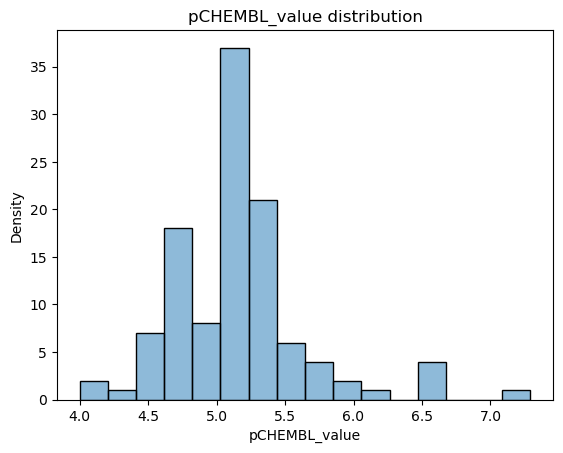

In [21]:
df3['pchembl_value'] = pd.to_numeric(df3['pchembl_value'], errors='coerce')
sns.histplot(
   data= df3, x="pchembl_value",
   fill=True, common_norm=False, palette="crest",
   alpha=.5, linewidth=1,
)

plt.xlabel("pCHEMBL_value")
plt.ylabel("Density")
plt.title("pCHEMBL_value distribution")

Text(0.5, 1.0, 'logP distribution')

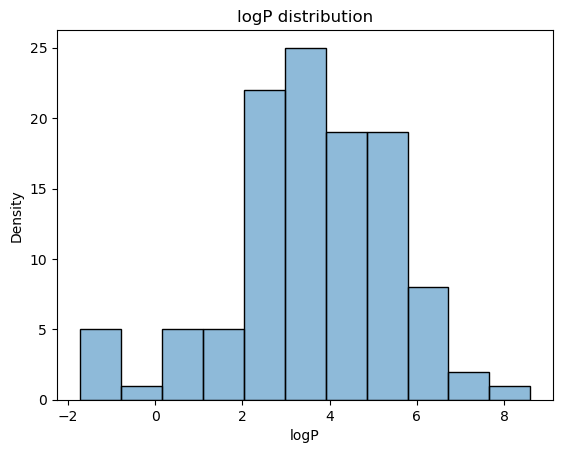

In [22]:
sns.histplot(
   data= df3, x="logP",
   fill=True, common_norm=False, palette="crest",
   alpha=.5, linewidth=1,
)

plt.xlabel("logP")
plt.ylabel("Density")
plt.title("logP distribution")

Text(0.5, 1.0, 'Molecular weight distribution')

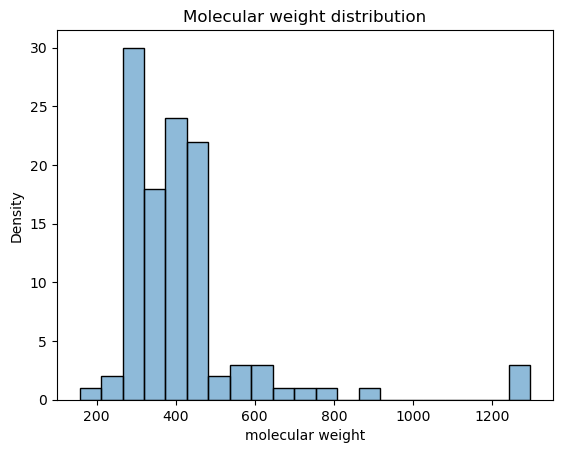

In [23]:
sns.histplot(
   data= df3, x="mw",
   fill=True, common_norm=False, palette="crest",
   alpha=.5, linewidth=1,
)

plt.xlabel("molecular weight")
plt.ylabel("Density")
plt.title("Molecular weight distribution")

As we can observe, we have outlier with excessive mw (>1000Da), once we identified it, we will dropped it.

In [24]:
discarded_compunds =["CHEMBL265502","CHEMBL3040216","CHEMBL265502"]
df3 = df3[~df3["molecule_chembl_id"].isin(discarded_compunds)]
df3.reset_index(drop=True, inplace=True)
df3

,molecule_chembl_id,canonical_smiles,pchembl_value,mw,logP
0,CHEMBL4848534,Cn1cc(SCC(=O)NCc2ccccc2)c2ccccc21,4.57,310.42,3.59
1,CHEMBL4864930,Cn1cc(SCC(=O)N(Cc2ccccc2)Cc2ccccc2)c2ccccc21,4.91,400.55,5.50
2,CHEMBL4850314,CN(C)CCOc1ccc(CNC(=O)CSc2cn(C)c3ccccc23)cc1,5.05,397.54,3.53
3,CHEMBL4851261,COc1ccccc1CNC(=O)CSc1cn(C)c2ccccc12,5.01,340.45,3.60
4,CHEMBL4860368,Cn1cc(SCC(=O)NCc2ccc(Cl)c(Cl)c2)c2ccccc21,5.12,379.31,4.89
...,...,...,...,...,...
104,CHEMBL461101,CC1=C(C=C(C=C1)N2C(=O)C(=C(N2)C)N=NC3=CC=CC(=C...,4.48,442.48,5.58
105,CHEMBL1484,CC1=C(C(C(=C(N1)C)C(=O)OCCN(C)CC2=CC=CC=C2)C3=...,4.70,479.53,3.68
106,CHEMBL51483,CC1=CC2=C(C(=C(C(=C2C(C)C)O)O)C=O)C(=C1C3=C(C4...,4.85,518.56,6.38
107,CHEMBL723,COC1=CC=CC=C1OCCNCC(COC2=CC=CC3=C2C4=CC=CC=C4...,5.12,406.48,3.74


The bioactivity data is in the IC50 unit. Compounds with pIC50 ≥ 5 will be considered **active**, while those with pIC50 < 4.6 will be considered **inactive**.

In [25]:
bioactivity_threshold = []
for i in df3.pchembl_value:
  if float(i) >= 5:
    bioactivity_threshold.append("active")
  elif float(i) < 4.6:
    bioactivity_threshold.append("inactive")
  else:
    pass

In [26]:
bioactivity_class = pd.Series(bioactivity_threshold, name='class')
bioactivity_class.reset_index(drop=True, inplace=True)
df3 = pd.concat([df3, bioactivity_class], axis=1)
df3 = df3[df3["class"].notna()]
df3

,molecule_chembl_id,canonical_smiles,pchembl_value,mw,logP,class
0,CHEMBL4848534,Cn1cc(SCC(=O)NCc2ccccc2)c2ccccc21,4.57,310.42,3.59,inactive
1,CHEMBL4864930,Cn1cc(SCC(=O)N(Cc2ccccc2)Cc2ccccc2)c2ccccc21,4.91,400.55,5.50,active
2,CHEMBL4850314,CN(C)CCOc1ccc(CNC(=O)CSc2cn(C)c3ccccc23)cc1,5.05,397.54,3.53,active
3,CHEMBL4851261,COc1ccccc1CNC(=O)CSc1cn(C)c2ccccc12,5.01,340.45,3.60,active
4,CHEMBL4860368,Cn1cc(SCC(=O)NCc2ccc(Cl)c(Cl)c2)c2ccccc21,5.12,379.31,4.89,active
...,...,...,...,...,...,...
82,CHEMBL4854368,CN(CC1=CC=CC=C1)C(=O)CSC2=CNC3=C2C=CC=C3Br,4.68,389.32,4.68,active
83,CHEMBL4848534,CN1C=C(C2=CC=CC=C21)SCC(=O)NCC3=CC=CC=C3,4.57,310.42,3.59,active
84,CHEMBL4526128,C1CCC(CC1)OC2=CC3=C(C=C2)SC4=C(C=C(C(=O)N34)C5...,4.56,582.68,6.02,active
85,CHEMBL4650320,CC(C)C(=O)OC[C@@H]1[C@H]([C@H]([C@@H](O1)N2C=C...,5.09,329.31,-1.14,inactive


In [27]:
df3['class'].value_counts() #We have 78 active compounds and 9 inactive compounds in the dataset

class
active      78
inactive     9
Name: count, dtype: int64

When working with large compound databases like ChEMBL, it's essential to use a single, most suitable SMILES representation for each compound

In [28]:
df3_no_smiles = df3.drop(columns='canonical_smiles')

smiles = df3['canonical_smiles'].apply(lambda x: max(str(x).split('.'), key=len))

df4 = pd.concat([df3_no_smiles, smiles], axis= 1)
df4['molecule_chembl_id'] = df4.apply(
    lambda x: 'active_' + x['molecule_chembl_id'] if x['class'] == 'active' else 'inactive_' + x['molecule_chembl_id'],
    axis=1
)
df4

,molecule_chembl_id,pchembl_value,mw,logP,class,canonical_smiles
0,inactive_CHEMBL4848534,4.57,310.42,3.59,inactive,Cn1cc(SCC(=O)NCc2ccccc2)c2ccccc21
1,active_CHEMBL4864930,4.91,400.55,5.50,active,Cn1cc(SCC(=O)N(Cc2ccccc2)Cc2ccccc2)c2ccccc21
2,active_CHEMBL4850314,5.05,397.54,3.53,active,CN(C)CCOc1ccc(CNC(=O)CSc2cn(C)c3ccccc23)cc1
3,active_CHEMBL4851261,5.01,340.45,3.60,active,COc1ccccc1CNC(=O)CSc1cn(C)c2ccccc12
4,active_CHEMBL4860368,5.12,379.31,4.89,active,Cn1cc(SCC(=O)NCc2ccc(Cl)c(Cl)c2)c2ccccc21
...,...,...,...,...,...,...
82,active_CHEMBL4854368,4.68,389.32,4.68,active,CN(CC1=CC=CC=C1)C(=O)CSC2=CNC3=C2C=CC=C3Br
83,active_CHEMBL4848534,4.57,310.42,3.59,active,CN1C=C(C2=CC=CC=C21)SCC(=O)NCC3=CC=CC=C3
84,active_CHEMBL4526128,4.56,582.68,6.02,active,C1CCC(CC1)OC2=CC3=C(C=C2)SC4=C(C=C(C(=O)N34)C5...
85,inactive_CHEMBL4650320,5.09,329.31,-1.14,inactive,CC(C)C(=O)OC[C@@H]1[C@H]([C@H]([C@@H](O1)N2C=C...


We generate a .smi file containing only the SMILES representations of our dataset compounds, which will be used to search for decoys using DecoysFinder.

In [29]:
df_smile = df3["canonical_smiles"]
#df_smile.to_csv("smiles.smi", sep='\t', index=False, header=False)

Adapted from https://github.com/URV-cheminformatics/DecoyFinder

Decoys are molecules that are presumed to be inactive against a target (i.e. will not likely bind to the target) and are used to validate the performance of molecular docking or a virtual screening workflow. To overcome this limitation, they have developed an application called DecoyFinder that selects, for a given collection of active ligands of a target, a set of decoys from a database of compounds. Decoys are selected if they are similar to active ligands according to five physical descriptors (molecular weight, number of rotational bonds, total hydrogen bond donors, total hydrogen bond acceptors and the octanol–water partition coefficient) without being chemically similar to any of the active ligands used as an input.

Once all decoys are found, we will generate Morgan fingerprints for each decoy using RDKit. Later, we will apply the same process to the other dataset (DF4).

In [30]:
sdf_file = '/home/yangxin/Desktop/script_rdrp/dataset/found_decoys_26_feb_decoys_2_decoys.sdf' #This file obtained with DecoysFinder contains 50 decoys per compound in the dataset.
mols = PandasTools.LoadSDF(sdf_file)

df_mf_inactive = []
for mol in mols['ROMol']:
  mf_bitvector = AllChem.GetMorganFingerprintAsBitVect(mol, radius=1, nBits = 2048)
  arr = np.zeros((0,), dtype=np.int8)
  DataStructs.ConvertToNumpyArray(mf_bitvector,arr)
  df_mf_inactive.append(arr)


df_MF_inactive = pd.concat([mols, pd.DataFrame(df_mf_inactive)], axis=1)

[12:49:39] DEPRECATION WARNING: please use MorganGenerator
[12:49:39] DEPRECATION WARNING: please use MorganGenerator
[12:49:39] DEPRECATION WARNING: please use MorganGenerator
[12:49:39] DEPRECATION WARNING: please use MorganGenerator
[12:49:39] DEPRECATION WARNING: please use MorganGenerator
[12:49:39] DEPRECATION WARNING: please use MorganGenerator
[12:49:39] DEPRECATION WARNING: please use MorganGenerator
[12:49:39] DEPRECATION WARNING: please use MorganGenerator
[12:49:39] DEPRECATION WARNING: please use MorganGenerator
[12:49:39] DEPRECATION WARNING: please use MorganGenerator
[12:49:39] DEPRECATION WARNING: please use MorganGenerator
[12:49:39] DEPRECATION WARNING: please use MorganGenerator
[12:49:39] DEPRECATION WARNING: please use MorganGenerator
[12:49:39] DEPRECATION WARNING: please use MorganGenerator
[12:49:39] DEPRECATION WARNING: please use MorganGenerator
[12:49:39] DEPRECATION WARNING: please use MorganGenerator
[12:49:39] DEPRECATION WARNING: please use MorganGenerat

In [31]:
df_MF_inactive["class"] = "inactive"
df_MF_inactive.rename(columns={"ID": "molecule_chembl_id", "ROMol":"mol"}, inplace=True) #Even though it is not a ChEMBL compound, we renamed it to facilitate the concatenating process of the datasets
df_MF_inactive['molecule_chembl_id'] = df_MF_inactive['molecule_chembl_id'].apply(lambda x: 'inactive_' + x)
df_MF_inactive

,molecule_chembl_id,mol,0,1,2,3,4,5,6,7,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,class
0,inactive_1661276,<rdkit.Chem.rdchem.Mol object at 0x7f8c26fd2c70>,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,inactive
1,inactive_3159147,<rdkit.Chem.rdchem.Mol object at 0x7f8c26f53300>,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,inactive
2,inactive_4559995,<rdkit.Chem.rdchem.Mol object at 0x7f8c26fd3d80>,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,inactive
3,inactive_7601953,<rdkit.Chem.rdchem.Mol object at 0x7f8c26f52ff0>,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,inactive
4,inactive_58151477,<rdkit.Chem.rdchem.Mol object at 0x7f8c26f52f10>,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,inactive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4345,inactive_160171801,<rdkit.Chem.rdchem.Mol object at 0x7f8c27d4c2e0>,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,inactive
4346,inactive_160197489,<rdkit.Chem.rdchem.Mol object at 0x7f8c27d4c350>,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,inactive
4347,inactive_160203971,<rdkit.Chem.rdchem.Mol object at 0x7f8c27d4c3c0>,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,inactive
4348,inactive_160222964,<rdkit.Chem.rdchem.Mol object at 0x7f8c27d4c430>,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,inactive


Now, we will generate Morgan fingerprints for our chEMBL compounds.

In [32]:
PandasTools.AddMoleculeColumnToFrame(df4,'canonical_smiles','mol')

In [ ]:
df_mf_chembl = []
for mol in df4['mol']:
  mf_bitvector = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits = 2048) 
  arr = np.zeros((0,), dtype=np.int8)
  DataStructs.ConvertToNumpyArray(mf_bitvector,arr)
  df_mf_chembl.append(arr)

df_MF_chembl_smiles = pd.concat([df4, pd.DataFrame(df_mf_chembl)], axis=1)

[12:49:43] DEPRECATION WARNING: please use MorganGenerator
[12:49:43] DEPRECATION WARNING: please use MorganGenerator
[12:49:43] DEPRECATION WARNING: please use MorganGenerator
[12:49:43] DEPRECATION WARNING: please use MorganGenerator
[12:49:43] DEPRECATION WARNING: please use MorganGenerator
[12:49:43] DEPRECATION WARNING: please use MorganGenerator
[12:49:43] DEPRECATION WARNING: please use MorganGenerator
[12:49:43] DEPRECATION WARNING: please use MorganGenerator
[12:49:43] DEPRECATION WARNING: please use MorganGenerator
[12:49:43] DEPRECATION WARNING: please use MorganGenerator
[12:49:43] DEPRECATION WARNING: please use MorganGenerator
[12:49:43] DEPRECATION WARNING: please use MorganGenerator
[12:49:43] DEPRECATION WARNING: please use MorganGenerator
[12:49:43] DEPRECATION WARNING: please use MorganGenerator
[12:49:43] DEPRECATION WARNING: please use MorganGenerator
[12:49:43] DEPRECATION WARNING: please use MorganGenerator
[12:49:43] DEPRECATION WARNING: please use MorganGenerat

In [34]:
df_MF_chembl_no_smiles = df_MF_chembl_smiles.copy()
df_MF_chembl_no_smiles = df_MF_chembl_smiles.drop(columns=["canonical_smiles"])
df_MF_chembl_no_smiles

,molecule_chembl_id,pchembl_value,mw,logP,class,mol,0,1,2,3,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,inactive_CHEMBL4848534,4.57,310.42,3.59,inactive,<rdkit.Chem.rdchem.Mol object at 0x7f8c27d4cf90>,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,active_CHEMBL4864930,4.91,400.55,5.50,active,<rdkit.Chem.rdchem.Mol object at 0x7f8c27d4d070>,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,active_CHEMBL4850314,5.05,397.54,3.53,active,<rdkit.Chem.rdchem.Mol object at 0x7f8c27d4d0e0>,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,active_CHEMBL4851261,5.01,340.45,3.60,active,<rdkit.Chem.rdchem.Mol object at 0x7f8c27d4e1f0>,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,active_CHEMBL4860368,5.12,379.31,4.89,active,<rdkit.Chem.rdchem.Mol object at 0x7f8c27d4d150>,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,active_CHEMBL4854368,4.68,389.32,4.68,active,<rdkit.Chem.rdchem.Mol object at 0x7f8c27d4f3e0>,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
83,active_CHEMBL4848534,4.57,310.42,3.59,active,<rdkit.Chem.rdchem.Mol object at 0x7f8c27d4f450>,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84,active_CHEMBL4526128,4.56,582.68,6.02,active,<rdkit.Chem.rdchem.Mol object at 0x7f8c27d4f4c0>,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
85,inactive_CHEMBL4650320,5.09,329.31,-1.14,inactive,<rdkit.Chem.rdchem.Mol object at 0x7f8c27d4f530>,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


We will concatenate the datasets containing fingerprint information, molecule_chembl_id and class.

In [35]:
df_dataset = pd.concat([df_MF_chembl_no_smiles, df_MF_inactive], axis=0)
df_dataset.reset_index(drop=True, inplace=True)
df_dataset

,molecule_chembl_id,pchembl_value,mw,logP,class,mol,0,1,2,3,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,inactive_CHEMBL4848534,4.57,310.42,3.59,inactive,<rdkit.Chem.rdchem.Mol object at 0x7f8c27d4cf90>,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,active_CHEMBL4864930,4.91,400.55,5.50,active,<rdkit.Chem.rdchem.Mol object at 0x7f8c27d4d070>,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,active_CHEMBL4850314,5.05,397.54,3.53,active,<rdkit.Chem.rdchem.Mol object at 0x7f8c27d4d0e0>,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,active_CHEMBL4851261,5.01,340.45,3.60,active,<rdkit.Chem.rdchem.Mol object at 0x7f8c27d4e1f0>,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,active_CHEMBL4860368,5.12,379.31,4.89,active,<rdkit.Chem.rdchem.Mol object at 0x7f8c27d4d150>,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4432,inactive_160171801,NaN,NaN,NaN,inactive,<rdkit.Chem.rdchem.Mol object at 0x7f8c27d4c2e0>,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4433,inactive_160197489,NaN,NaN,NaN,inactive,<rdkit.Chem.rdchem.Mol object at 0x7f8c27d4c350>,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4434,inactive_160203971,NaN,NaN,NaN,inactive,<rdkit.Chem.rdchem.Mol object at 0x7f8c27d4c3c0>,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4435,inactive_160222964,NaN,NaN,NaN,inactive,<rdkit.Chem.rdchem.Mol object at 0x7f8c27d4c430>,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
#df_dataset.to_csv('rdrp_03_bioactivity_data_curated.csv', index=False)

# **Scaffolds generation**

Machine learning models are often unreliable when the data they encounter in real-world use differs fundamentally from the data they were trained on, potentially leading to inaccurate and misleading predictions. This is why, instead of using a random split for training our dataset, we will use Scaffold Split. A scaffold is a foundational molecular structure with desirable properties, which allows us to assess how well models can predict foreign molecular structures. As a result, every molecule in the test set has a scaffold that is unique and molecularly distant from those in the training set. As a cautionary note, prediction accuracy is generally lower under scaffold splitting, which actually confirms the effectiveness of this method. We expect lower accuracy because the model has never seen these types of molecules before, unlike with a random split.

In [110]:
def generate_scaffolds(mols):
    scaffolds = collections.defaultdict(list)
    for idx, mol in enumerate(mols):
        scaffold = MurckoScaffold.MurckoScaffoldSmiles(mol=mol, includeChirality=False)
        scaffolds[scaffold].append(idx)
    scaffolds = {key: sorted(value) for key, value in scaffolds.items()}
    scaffold_sets = [
        scaffold_set for (_, scaffold_set) in sorted(
            scaffolds.items(), key=lambda x: (len(x[1]), x[1][0]), reverse=True)
    ]
    return scaffold_sets

def generate_scaffold_groups(mols):
    scaffolds = generate_scaffolds(mols)
    scaffold_matrix = np.zeros((len(mols), len(scaffolds)), dtype=int)

    for s_id, m_id_list in enumerate(scaffolds):
        for m_id in m_id_list:
            scaffold_matrix[m_id, s_id] = 1

    groups = [''.join(map(str, yy)) for yy in scaffold_matrix]
    return np.array(groups)

In [111]:
scaffold_groups = generate_scaffold_groups(df_dataset['mol'])
group_label_dict = {group_label: idx for idx, group_label in enumerate(scaffold_groups)}
groups_int = [group_label_dict[group_label] for group_label in scaffold_groups]

In [112]:
#df_group_int = pd.DataFrame(groups_int, columns = ['index'])
#df_group_int.to_csv('groups_int', index = False)

In [113]:
df_scaffold = df_dataset.copy()
PandasTools.AddMurckoToFrame(df_scaffold, molCol='mol', MurckoCol='Murcko_SMILES', Generic=False)
df_scaffold['scaffold_groups'] = pd.DataFrame(groups_int)

df_scaffold = df_scaffold[['molecule_chembl_id', 'Murcko_SMILES','mol','scaffold_groups', 'class']]
df_scaffold

,molecule_chembl_id,Murcko_SMILES,mol,scaffold_groups,class
0,inactive-CHEMBL4848534,O=C(CSc1c[nH]c2ccccc12)NCc1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x7f929107e650>,83,inactive
1,active-CHEMBL4864930,O=C(CSc1c[nH]c2ccccc12)N(Cc1ccccc1)Cc1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x7f9288655000>,55,active
2,active-CHEMBL4850314,O=C(CSc1c[nH]c2ccccc12)NCc1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x7f92886550e0>,83,active
3,active-CHEMBL4851261,O=C(CSc1c[nH]c2ccccc12)NCc1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x7f9288655150>,83,active
4,active-CHEMBL4860368,O=C(CSc1c[nH]c2ccccc12)NCc1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x7f9288654dd0>,83,active
...,...,...,...,...,...
4432,inactive-160171801,C1CCCCC1,<rdkit.Chem.rdchem.Mol object at 0x7f9288654890>,4432,inactive
4433,inactive-160197489,O=C(NCc1cocn1)C1CCCCO1,<rdkit.Chem.rdchem.Mol object at 0x7f9288654900>,4433,inactive
4434,inactive-160203971,C1CC1,<rdkit.Chem.rdchem.Mol object at 0x7f9288654970>,4434,inactive
4435,inactive-160222964,c1cn[nH]c1,<rdkit.Chem.rdchem.Mol object at 0x7f92886549e0>,4435,inactive


In [114]:
df_scaffold_active = df_scaffold[["scaffold_groups","class"]]
df_scaffold_active = df_scaffold_active[df_scaffold_active["class"] == "active"]
df_scaffold_active = df_scaffold_active.reset_index(drop=True)
df_scaffold_active = df_scaffold_active.groupby("scaffold_groups").size()
df_scaffold_active


scaffold_groups
18     1
40     1
48     1
49     1
51     2
52     1
54     2
55     6
65     2
68     2
71     2
73     4
75    14
77     1
80     1
81     2
83    32
84     2
86     1
dtype: int64

In [115]:
scaffold_groups_count = df_scaffold.groupby(['scaffold_groups']).size()
amount = df_scaffold.groupby(['scaffold_groups'])['molecule_chembl_id'].agg(list)
df_scaffold_groups = pd.DataFrame({'Amount': scaffold_groups_count, 'Compound_list': amount})
df_scaffold_groups = df_scaffold_groups.sort_values(by='Amount', ascending=False)
print(df_scaffold_groups)
print(f"Number of scaffolds: {len(df_scaffold_groups)}, with a total of {df_scaffold.shape[0]} compounds")

                 Amount                                      Compound_list
scaffold_groups                                                           
4422                340  [inactive-6402223, inactive-95415693, inactive...
2836                 37  [inactive-4217426, inactive-11615757, inactive...
83                   35  [inactive-CHEMBL4848534, active-CHEMBL4850314,...
4410                 31  [inactive-3518713, inactive-57536137, inactive...
4411                 24  [inactive-103542515, inactive-100922006, inact...
...                 ...                                                ...
1041                  1                               [inactive-104293355]
1046                  1                                 [inactive-5420221]
1047                  1                                 [inactive-4739521]
4423                  1                                [inactive-94102117]
4424                  1                               [inactive-160192013]

[2752 rows x 2 columns]


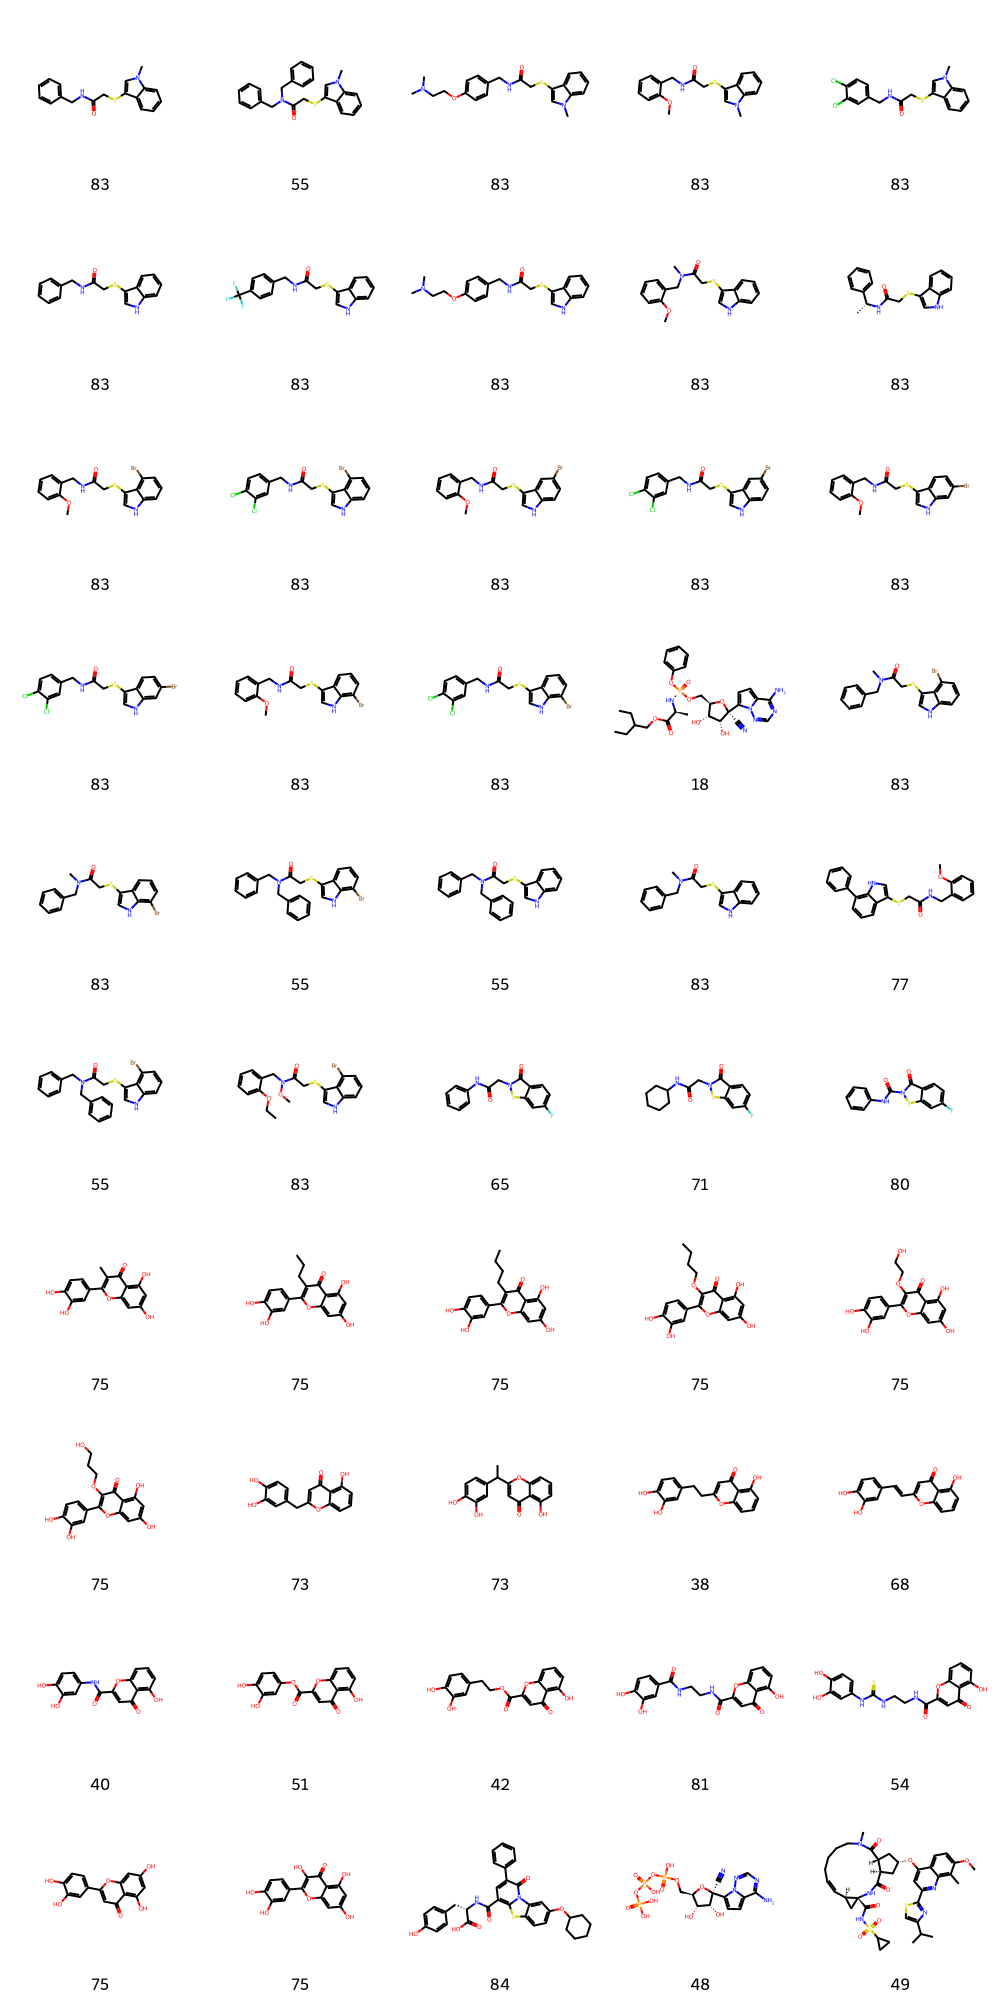

In [116]:
PandasTools.FrameToGridImage(df_scaffold, column='mol', legendsCol='scaffold_groups', molsPerRow=5) #The number below the compound represents the scaffold group to which it belongs

We will highlight the scaffolds, which are the molecular structures with desirable properties of each compound, in order to compare them when we split the compounds into training and test sets.

In [117]:
def get_highlight_atoms(mol, murcko_smiles): # Generate a list of atoms that are common between the scaffold structure and the molecule structure
  scaffold = Chem.MolFromSmiles(murcko_smiles)
  match = mol.GetSubstructMatch(scaffold)
  return list(match)

In [118]:
hl_atom_list = [get_highlight_atoms(mol, scaffold_smiles) for mol, scaffold_smiles in zip(df_scaffold['mol'], df_scaffold['Murcko_SMILES'])]

img = Draw.MolsToGridImage(df_scaffold['mol'].tolist(),
                     legends = [str(x) for x in df_scaffold['scaffold_groups'].tolist()], # Scaffold group to which it belongs
                     highlightAtomLists = hl_atom_list,
                     molsPerRow=5,
                     subImgSize=(300,300), useSVG=False)

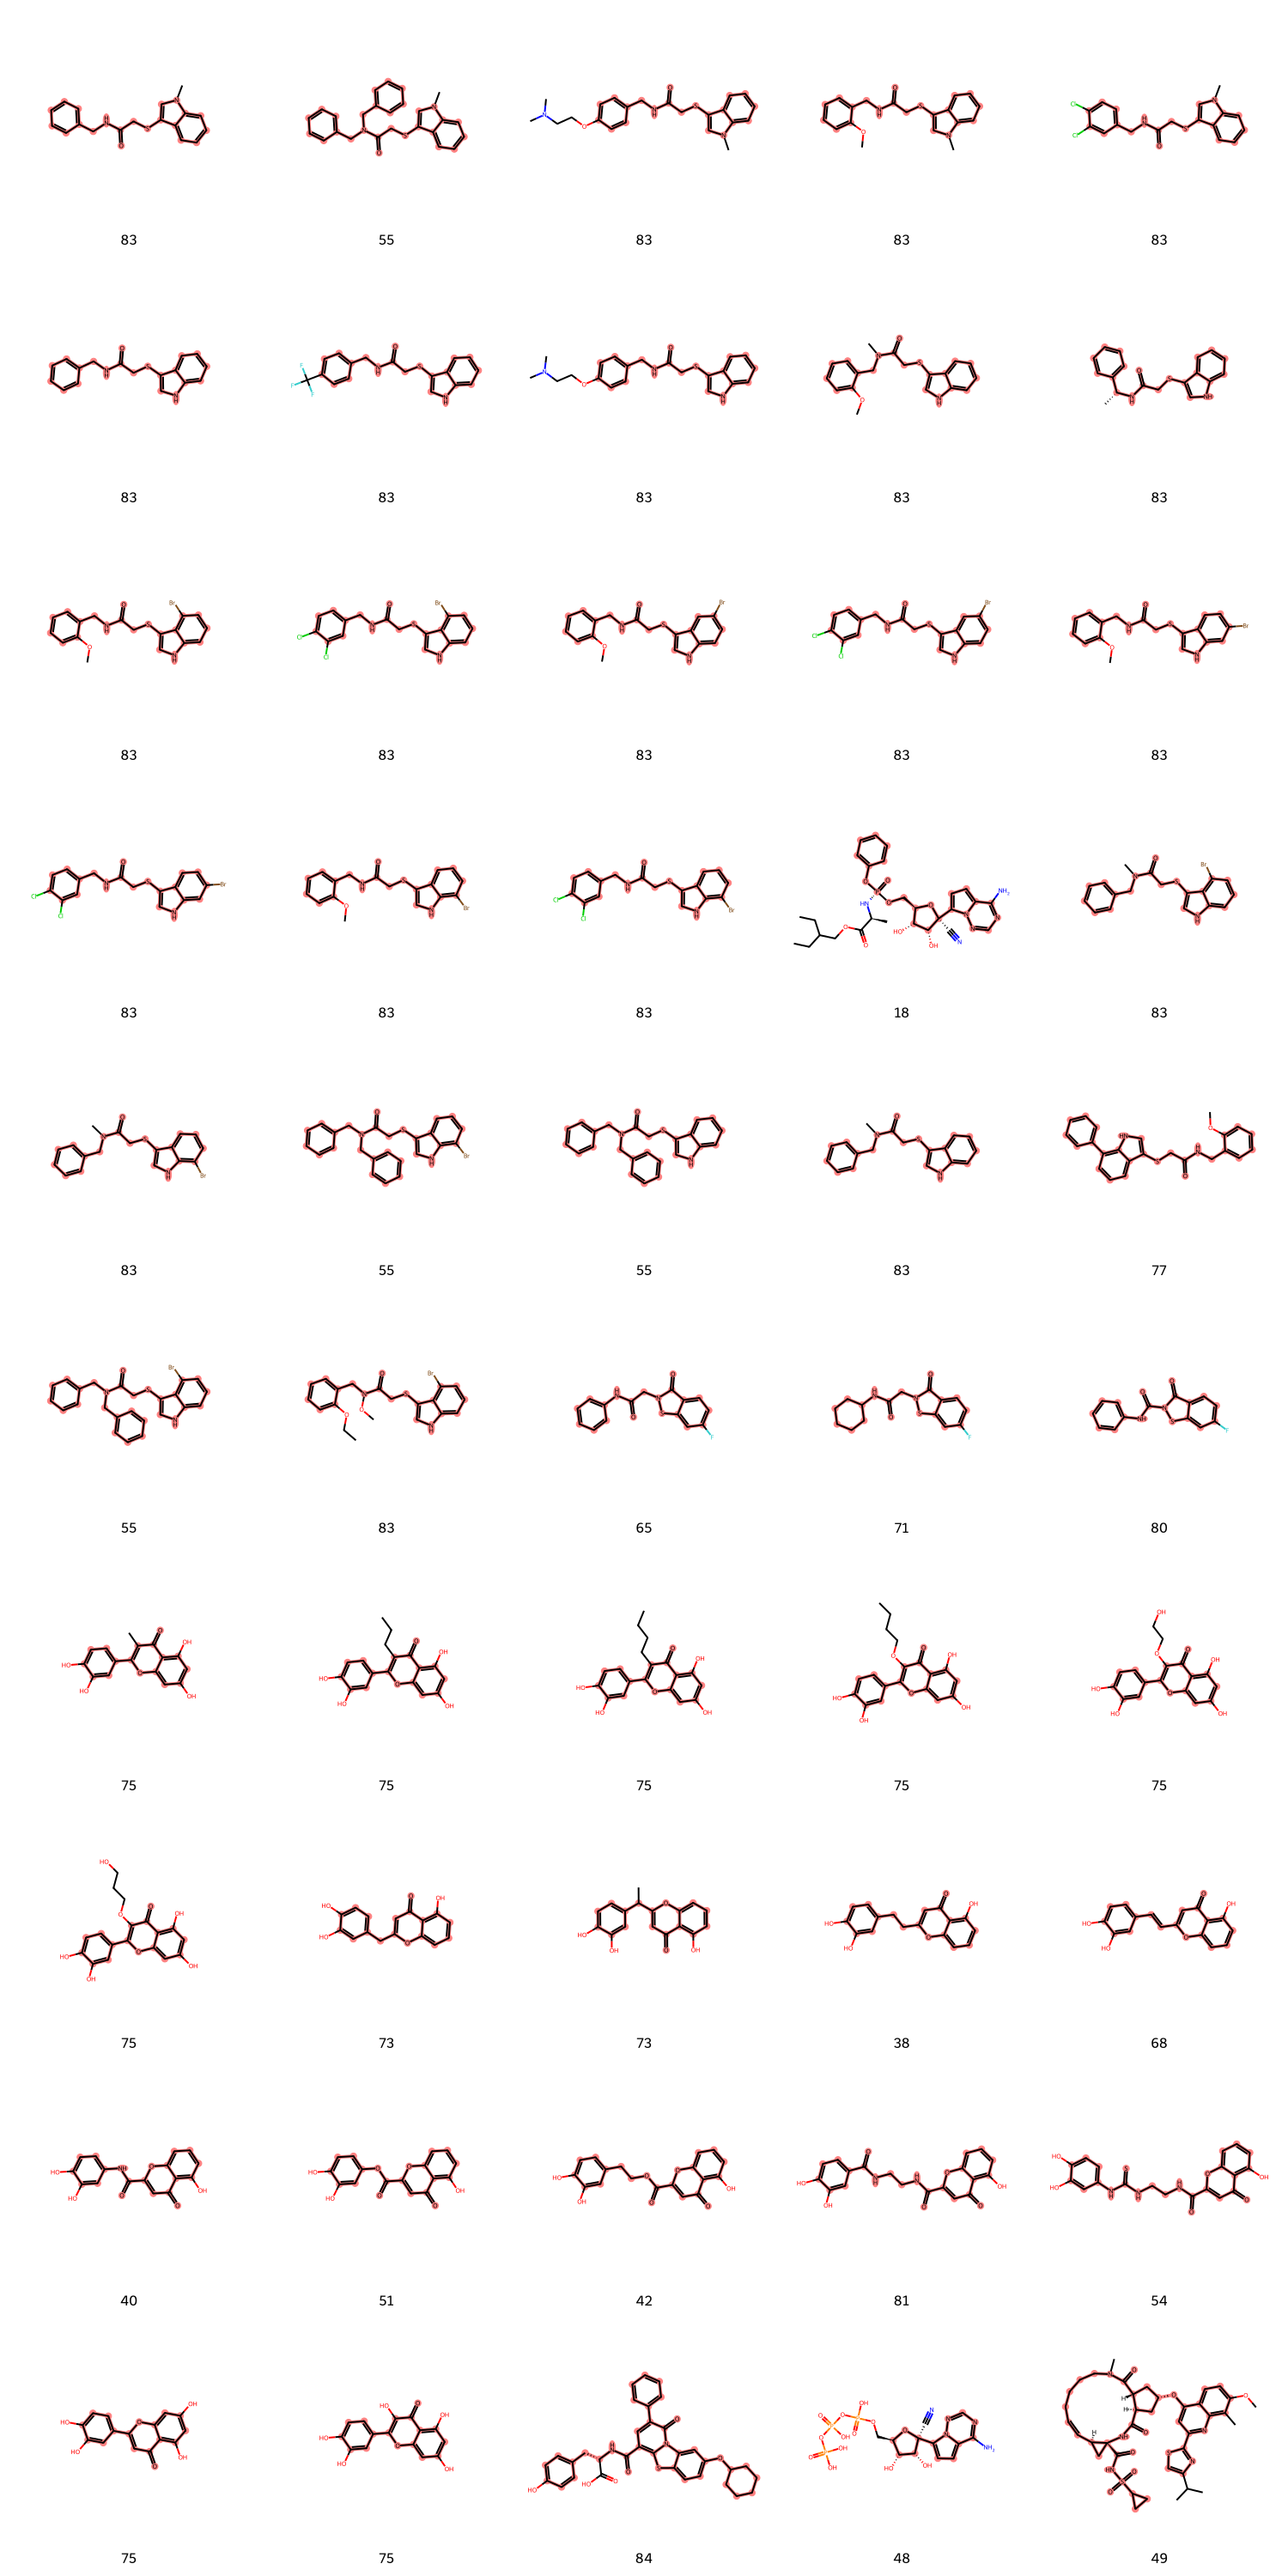

In [119]:
img

# **Preparing X and Y data matrices**

The x variable contains all the information used to predict the y variable, while the y variable represents the original outcome that we aim to evaluate.

### **X data matrices**


In [46]:
x = df_dataset.drop(columns=['molecule_chembl_id',"class","pchembl_value","mw","logP","mol"])
x

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4345,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4346,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4347,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4348,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### **Y data matrices**


In [47]:
y = df_dataset["class"]
y.value_counts()

class
inactive    4359
active        78
Name: count, dtype: int64

# **Model comparison**

When comparing different models, lazy classifier serve as a benchmark to evaluate the performance of more complex algorithms.

They are useful in model comparison because:

1. Minimal Training Time: Since they don't require a training phase, lazy classifiers can be quickly tested against other models.

2. Flexibility: Their performance can be sensitive to hyperparameters (like the number of neighbors in k-NN), so they offer insights into how other models might behave with similar settings.

2. Benchmarking: They provide a simple reference point for evaluating how more sophisticated models (e.g., decision trees, neural networks) perform in terms of accuracy, speed, and scalability

### **Lazy Classifier**

First we will remove low variance features because these features do not provide much useful information for the model using Bernoulli distribution which it's useful when we work with binary data.

In [48]:
selection = VarianceThreshold(threshold=(.8 * (1 - .8)))
x = selection.fit_transform(x)
x.shape

(4437, 23)

Next, we will split the dataset using StratifiedGroupKFold, which aims to create folds that preserve the class distribution as much as possible while ensuring that groups do not overlap between splits. We will perform cross-validation to evaluate the entire dataset.

In [49]:
sgk = StratifiedGroupKFold(n_splits=5)
sgk.get_n_splits(x, y)

5

In [50]:
for train_idx, test_idx in sgk.split(x, y, groups_int):
    x_train, x_test = x[train_idx], x[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]


In [51]:
train_dist_inicial = Counter(y.iloc[train_idx])
test_dist_inicial = Counter(y.iloc[test_idx])

active_proportion_train = train_dist_inicial['active'] / (train_dist_inicial['active'] + train_dist_inicial['inactive'])
inactive_proportion_train = train_dist_inicial['inactive'] / (train_dist_inicial['active'] + train_dist_inicial['inactive'])
active_proportion_test = test_dist_inicial['active'] / (test_dist_inicial['active'] + test_dist_inicial['inactive'])
inactive_proportion_test = test_dist_inicial['inactive'] / (test_dist_inicial['active'] + test_dist_inicial['inactive'])

print(f"Initial proportion")
print(f"  Train class distribution: {train_dist_inicial}")
print(f"  Test class distribution: {test_dist_inicial}")
print(f"  Traning class proportion: {active_proportion_train:.2f} active to {inactive_proportion_train:.2f} inactive")
print(f"  Test class proportion: {active_proportion_test:.2f} active to {inactive_proportion_test:.2f} inactive")

Initial proportion
  Train class distribution: Counter({'inactive': 3488, 'active': 64})
  Test class distribution: Counter({'inactive': 871, 'active': 14})
  Traning class proportion: 0.02 active to 0.98 inactive
  Test class proportion: 0.02 active to 0.98 inactive


In [52]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((3552, 23), (885, 23), (3552,), (885,))

In [53]:
comparation = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = comparation.fit(x_train, x_test, y_train, y_test)

100%|██████████| 32/32 [00:02<00:00, 12.87it/s]

[LightGBM] [Info] Number of positive: 3488, number of negative: 64
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001771 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 69
[LightGBM] [Info] Number of data points in the train set: 3552, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.981982 -> initscore=3.998201
[LightGBM] [Info] Start training from score 3.998201


In [54]:
# Performance table of the training set (80% subset)
predictions

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
GaussianNB,0.72,0.86,None,0.82,0.02
LabelSpreading,0.98,0.64,None,0.98,0.62
LabelPropagation,0.98,0.64,None,0.98,0.56
NearestCentroid,0.81,0.52,None,0.88,0.02
AdaBoostClassifier,0.98,0.50,None,0.98,0.20
LinearSVC,0.98,0.50,None,0.98,0.03
DummyClassifier,0.98,0.50,None,0.98,0.01
RidgeClassifierCV,0.98,0.50,None,0.98,0.02
PassiveAggressiveClassifier,0.98,0.50,None,0.98,0.02


In [55]:
# Performance table of the test set (20% subset)
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
GaussianNB,0.72,0.86,None,0.82,0.02
LabelSpreading,0.98,0.64,None,0.98,0.62
LabelPropagation,0.98,0.64,None,0.98,0.56
NearestCentroid,0.81,0.52,None,0.88,0.02
AdaBoostClassifier,0.98,0.50,None,0.98,0.20
LinearSVC,0.98,0.50,None,0.98,0.03
DummyClassifier,0.98,0.50,None,0.98,0.01
RidgeClassifierCV,0.98,0.50,None,0.98,0.02
PassiveAggressiveClassifier,0.98,0.50,None,0.98,0.02


When we use a lazy classifier, we generally trust model dataframe because it reflects how well the model performs on a separate dataset that it has never seen before, while prediction reflects how well the model performs on the data it was trained on. This is why the results from the model dataframe suggest that the GaussianNB and LabelSpreading seem to perform better. Now, we will try different models to see which one works best. Additionally, we will use the RandomForestRegressor as well, because it is a standard model that usually performs well.

# **Model deployment**

### **RandomForestClassifier**

In [56]:
model1 = RandomForestClassifier(random_state=42)

Cross-validation is a machine learning technique used to assess a model’s performance on unseen data. It involves splitting the dataset into multiple folds, training the model on some folds while using one for validation, and repeating the process multiple times. K-Fold Cross Validation, a common approach, divides the data into k subsets, iterating k times with a different fold for testing each time. This ensures a more reliable performance estimate and improves model generalization.

In [57]:
specificity_scorer = make_scorer(specificity_score, average='weighted')

In [58]:
scoring = {
    'balanced_accuracy': 'balanced_accuracy',
    'roc_auc': 'roc_auc',
    'matthews_corrcoef': 'matthews_corrcoef',
    'f1_weighted': 'f1_weighted',
    'precision_weighted': 'precision_weighted',
    'recall_weighted': 'recall_weighted',
    'specificity_weighted': specificity_scorer
}

In [59]:
num_folds = 5
StraGroupKFold = StratifiedGroupKFold(n_splits=num_folds)
cross_val_results = cross_validate(model1, x, y, cv=StraGroupKFold, scoring= scoring, groups= groups_int)
cross_val_results

{'fit_time': array([0.1391468 , 0.14866066, 0.15326977, 0.1384902 , 0.14671135]),
 'score_time': array([0.03189135, 0.03399706, 0.03354669, 0.03130245, 0.03159404]),
 'test_balanced_accuracy': array([0.58861814, 0.59713303, 0.54201418, 0.5       , 0.49885189]),
 'test_roc_auc': array([0.91919192, 0.93411697, 0.81849458, 0.75346226, 0.75635558]),
 'test_matthews_corrcoef': array([ 0.23929477,  0.23179396,  0.10509435,  0.        , -0.00603378]),
 'test_f1_weighted': array([0.98315248, 0.98397291, 0.97988735, 0.94716347, 0.97520309]),
 'test_precision_weighted': array([0.98158136, 0.98286233, 0.9780488 , 0.93038095, 0.96857657]),
 'test_recall_weighted': array([0.98529412, 0.98526077, 0.98187995, 0.96456257, 0.9819209 ]),
 'test_specificity_weighted': array([0.19194216, 0.20900528, 0.1021484 , 0.03543743, 0.01578288])}

In [60]:
for i, (train_idx, test_idx) in enumerate(StraGroupKFold.split(x, y, groups=groups_int)):
    train_dist = Counter(y.iloc[train_idx])
    test_dist = Counter(y.iloc[test_idx])
    active_proportion_train = train_dist['active'] / (train_dist['active'] + train_dist['inactive'])
    inactive_proportion_train = train_dist['inactive'] / (train_dist['active'] + train_dist['inactive'])
    active_proportion_test = test_dist['active'] / (test_dist['active'] + test_dist['inactive'])
    inactive_proportion_test = test_dist['inactive'] / (test_dist['active'] + test_dist['inactive'])

    print(f"Fold {i+1}:")
    print(f"  Train class distribution: {train_dist}")
    print(f"  Test class distribution: {test_dist}")
    print(f"  Traning class proportion: {active_proportion_train:.2f} active to {inactive_proportion_train:.2f} inactive")
    print(f"  Test class proportion: {active_proportion_test:.2f} active to {inactive_proportion_test:.2f} inactive")

Fold 1:
  Train class distribution: Counter({'inactive': 3486, 'active': 67})
  Test class distribution: Counter({'inactive': 873, 'active': 11})
  Traning class proportion: 0.02 active to 0.98 inactive
  Test class proportion: 0.01 active to 0.99 inactive
Fold 2:
  Train class distribution: Counter({'inactive': 3487, 'active': 68})
  Test class distribution: Counter({'inactive': 872, 'active': 10})
  Traning class proportion: 0.02 active to 0.98 inactive
  Test class proportion: 0.01 active to 0.99 inactive
Fold 3:
  Train class distribution: Counter({'inactive': 3487, 'active': 67})
  Test class distribution: Counter({'inactive': 872, 'active': 11})
  Traning class proportion: 0.02 active to 0.98 inactive
  Test class proportion: 0.01 active to 0.99 inactive
Fold 4:
  Train class distribution: Counter({'inactive': 3488, 'active': 46})
  Test class distribution: Counter({'inactive': 871, 'active': 32})
  Traning class proportion: 0.01 active to 0.99 inactive
  Test class proportion: 0

In [61]:
result_model1_1 = cross_val_results["test_balanced_accuracy"].mean()
result_model1_2 = cross_val_results["test_roc_auc"].mean()
result_model1_3 = cross_val_results["test_matthews_corrcoef"].mean()
result_model1_4 = cross_val_results["test_f1_weighted"].mean()
result_model1_5 = cross_val_results["test_precision_weighted"].mean()
result_model1_6 = cross_val_results["test_recall_weighted"].mean()
result_model1_7 = cross_val_results["test_specificity_weighted"].mean()
results_model1 = [result_model1_1, result_model1_2, result_model1_3, result_model1_4, result_model1_5, result_model1_6, result_model1_7]

In [62]:
print(f'Mean Balanced_accuracy: {result_model1_1}')
print(f'Mean Roc_auc: {result_model1_2}')
print(f'Mean Matthews_corrcoef: {result_model1_3}')
print(f'Mean F1_weighted: {result_model1_4}')
print(f'Mean Precision_weighted: {result_model1_5}')
print(f'Mean Recall_weighted: {result_model1_6}')
print(f'Mean Specificity_weighted: {result_model1_7}')


Mean Balanced_accuracy: 0.5453234481087637
Mean Roc_auc: 0.8363242622452024
Mean Matthews_corrcoef: 0.11402986076915037
Mean F1_weighted: 0.9738758591931393
Mean Precision_weighted: 0.9682899997088787
Mean Recall_weighted: 0.9797836632981074
Mean Specificity_weighted: 0.11086323291942013


In [63]:
df_model_1 = pd.DataFrame(results_model1)
df_model_1 = df_model_1.transpose()
df_model_1.columns = ['balanced_accuracy', 'roc_auc', 'matthews_corrcoef', 'f1_weighted', 'precision_weighted', 'recall_weighted', 'specificity_weighted']
df_model_1

,balanced_accuracy,roc_auc,matthews_corrcoef,f1_weighted,precision_weighted,recall_weighted,specificity_weighted
0,0.55,0.84,0.11,0.97,0.97,0.98,0.11


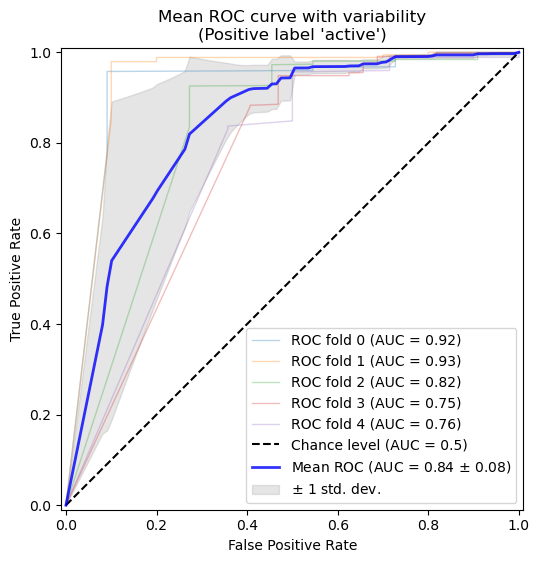

In [64]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(StraGroupKFold.split(x, y, groups=groups_int)):
    model1.fit(x[train], y.iloc[train])
    viz = RocCurveDisplay.from_estimator(
        model1,
        x[test],
        y.iloc[test],
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
        plot_chance_level=(fold == num_folds - 1),
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability\n(Positive label 'active')",
)
ax.legend(loc="lower right")
plt.show()

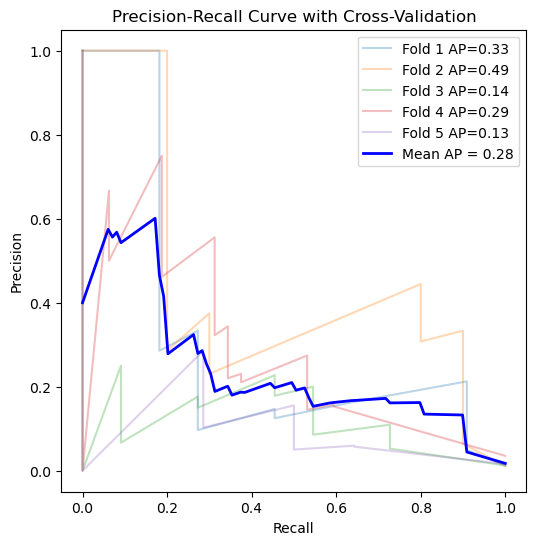

In [65]:
precisions = []
recalls = []
aps = []
mean_recall = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(6, 6))

for fold, (train_idx, test_idx) in enumerate(StraGroupKFold.split(x, y, groups=groups_int)):
    model1.fit(x[train_idx], y.iloc[train_idx])

    y_pred_prob = model1.predict_proba(x[test_idx])[:, 0]

    precision, recall, _ = precision_recall_curve(y.iloc[test_idx], y_pred_prob, pos_label= "active")
    ap = average_precision_score(y.iloc[test_idx], y_pred_prob, pos_label= "active")

    interp_precision = np.interp(mean_recall, recall[::-1], precision[::-1])

    precisions.append(interp_precision)
    aps.append(ap)

    ax.plot(recall, precision, alpha=0.3, label=f'Fold {fold+1} AP={ap:.2f}')

mean_precision = np.mean(precisions, axis=0)
mean_ap = np.mean(aps)

ax.plot(mean_recall, mean_precision, color='b', lw=2, label=f'Mean AP = {mean_ap:.2f}')
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Precision-Recall Curve with Cross-Validation")
ax.legend()
plt.show()

In [66]:
pr_auc_values_1 = pd.DataFrame(data = [0.28], index= ['RandomForestClassifier (g.s)'])

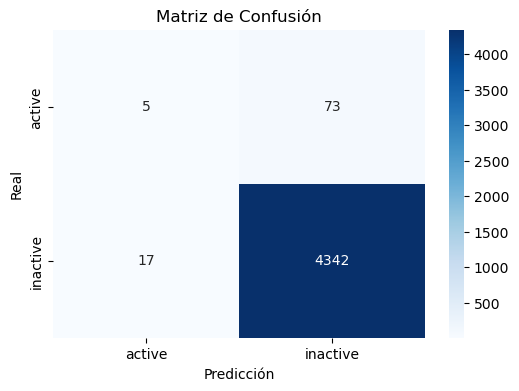

In [67]:
y_prediction = cross_val_predict(model1, x, y, cv=StraGroupKFold, groups=groups_int)

cm_1 = confusion_matrix(y, y_prediction)

plt.figure(figsize=(6,4))
sns.heatmap(cm_1, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

### **ExtraTreesClassifier**

In [68]:
model2 = ExtraTreesClassifier(n_estimators=100, random_state=0)

In [69]:
specificity_scorer = make_scorer(specificity_score, average='weighted')

In [70]:
scoring = {
    'balanced_accuracy': 'balanced_accuracy',
    'roc_auc': 'roc_auc',
    'matthews_corrcoef': 'matthews_corrcoef',
    'f1_weighted': 'f1_weighted',
    'precision_weighted': 'precision_weighted',
    'recall_weighted': 'recall_weighted',
    'specificity_weighted': specificity_scorer
}

In [71]:
num_folds = 5
StraGroupKFold2 = StratifiedGroupKFold(n_splits=num_folds)
cross_val_results_2 = cross_validate(model2, x, y, cv=StraGroupKFold2, scoring= scoring, groups= groups_int)
cross_val_results_2

{'fit_time': array([0.12746477, 0.13042283, 0.1348424 , 0.13302469, 0.12958479]),
 'score_time': array([0.03336644, 0.03294134, 0.03396869, 0.03366828, 0.03246641]),
 'test_balanced_accuracy': array([0.58861814, 0.59713303, 0.54201418, 0.49942595, 0.49770379]),
 'test_roc_auc': array([0.83005311, 0.88440367, 0.74223311, 0.64491246, 0.7130556 ]),
 'test_matthews_corrcoef': array([ 0.23929477,  0.23179396,  0.10509435, -0.00638209, -0.00854274]),
 'test_f1_weighted': array([0.98315248, 0.98397291, 0.97988735, 0.94660963, 0.97406934]),
 'test_precision_weighted': array([0.98158136, 0.98286233, 0.9780488 , 0.93034305, 0.96854114]),
 'test_recall_weighted': array([0.98529412, 0.98526077, 0.98187995, 0.96345515, 0.97966102]),
 'test_specificity_weighted': array([0.19194216, 0.20900528, 0.1021484 , 0.03539674, 0.01574656])}

In [72]:
result_model2_1 = cross_val_results_2["test_balanced_accuracy"].mean()
result_model2_2 = cross_val_results_2["test_roc_auc"].mean()
result_model2_3 = cross_val_results_2["test_matthews_corrcoef"].mean()
result_model2_4 = cross_val_results_2["test_f1_weighted"].mean()
result_model2_5 = cross_val_results_2["test_precision_weighted"].mean()
result_model2_6 = cross_val_results_2["test_recall_weighted"].mean()
result_model2_7 = cross_val_results_2["test_specificity_weighted"].mean()

results_model2 = [result_model2_1, result_model2_2, result_model2_3, result_model2_4, result_model2_5, result_model2_6, result_model2_7]

In [73]:
print(f'Mean Balanced_accuracy: {result_model2_1}')
print(f'Mean Roc_auc: {result_model2_2}')
print(f'Mean Matthews_corrcoef: {result_model2_3}')
print(f'Mean F1_weighted: {result_model2_4}')
print(f'Mean Precision_weighted: {result_model2_5}')
print(f'Mean Recall_weighted: {result_model2_6}')
print(f'Mean Specificity_weighted: {result_model2_7}')

Mean Balanced_accuracy: 0.5449790164210484
Mean Roc_auc: 0.7629315894231015
Mean Matthews_corrcoef: 0.1122516527305335
Mean F1_weighted: 0.9735383423006025
Mean Precision_weighted: 0.9682753358570008
Mean Recall_weighted: 0.9791102019545631
Mean Specificity_weighted: 0.1108478308875337


In [74]:
df_model_2 = pd.DataFrame(results_model2)
df_model_2 = df_model_2.transpose()
df_model_2.columns = ['balanced_accuracy', 'roc_auc', 'matthews_corrcoef', 'f1_weighted', 'precision_weighted', 'recall_weighted', 'specificity_weighted']
df_model_2

,balanced_accuracy,roc_auc,matthews_corrcoef,f1_weighted,precision_weighted,recall_weighted,specificity_weighted
0,0.54,0.76,0.11,0.97,0.97,0.98,0.11


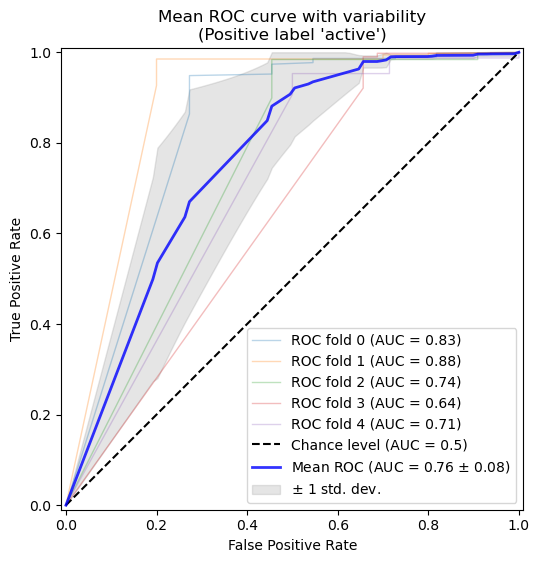

In [75]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(StraGroupKFold2.split(x, y, groups=groups_int)):
    model2.fit(x[train], y.iloc[train])
    viz = RocCurveDisplay.from_estimator(
        model2,
        x[test],
        y.iloc[test],
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
        plot_chance_level=(fold == num_folds - 1),
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability\n(Positive label 'active')",
)
ax.legend(loc="lower right")
plt.show()

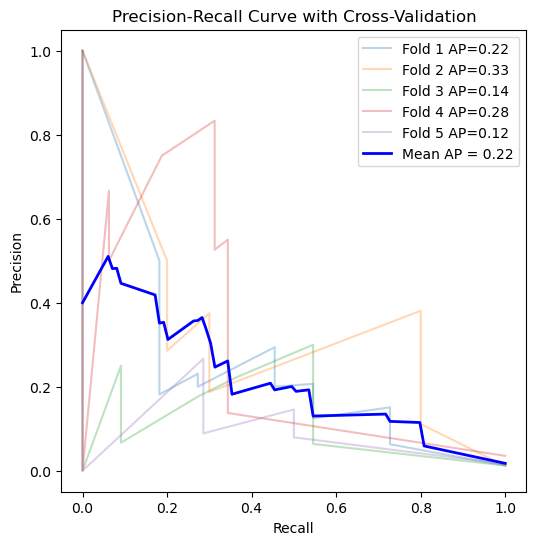

In [76]:
precisions = []
recalls = []
aps = []
mean_recall = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(6, 6))

for fold, (train_idx, test_idx) in enumerate(StraGroupKFold2.split(x, y, groups=groups_int)):
    model2.fit(x[train_idx], y.iloc[train_idx])

    y_pred_prob = model2.predict_proba(x[test_idx])[:, 0]

    precision, recall, _ = precision_recall_curve(y.iloc[test_idx], y_pred_prob, pos_label= "active")
    ap = average_precision_score(y.iloc[test_idx], y_pred_prob, pos_label= "active")

    interp_precision = np.interp(mean_recall, recall[::-1], precision[::-1])

    precisions.append(interp_precision)
    aps.append(ap)

    ax.plot(recall, precision, alpha=0.3, label=f'Fold {fold+1} AP={ap:.2f}')

mean_precision = np.mean(precisions, axis=0)
mean_ap = np.mean(aps)

ax.plot(mean_recall, mean_precision, color='b', lw=2, label=f'Mean AP = {mean_ap:.2f}')
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Precision-Recall Curve with Cross-Validation")
ax.legend()
plt.show()

In [77]:
pr_auc_values_2 = pd.DataFrame(data = [0.22], index= ['LightGBM (g.s)'])

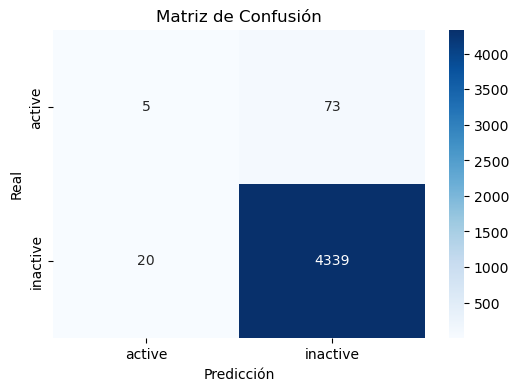

In [78]:
y_prediction_2 = cross_val_predict(model2, x, y, cv=StraGroupKFold2, groups=groups_int)

cm_2 = confusion_matrix(y, y_prediction_2)

plt.figure(figsize=(6,4))
sns.heatmap(cm_2, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

### **LabelSpreading**

In [79]:
model3 = LabelSpreading()

In [80]:
specificity_scorer = make_scorer(specificity_score, average='weighted')

In [81]:
scoring = {
    'balanced_accuracy': 'balanced_accuracy',
    'roc_auc': 'roc_auc',
    'matthews_corrcoef': 'matthews_corrcoef',
    'f1_weighted': 'f1_weighted',
    'precision_weighted': 'precision_weighted',
    'recall_weighted': 'recall_weighted',
    'specificity_weighted': specificity_scorer
}

In [82]:
num_folds = 5
StraGroupKFold3 = StratifiedGroupKFold(n_splits=num_folds)
cross_val_results_3 = cross_validate(model3, x, y, cv=StraGroupKFold3, scoring= scoring, groups= groups_int)
cross_val_results_3

{'fit_time': array([0.45076346, 0.44453907, 0.42162013, 0.41814303, 0.41657758]),
 'score_time': array([0.2131536 , 0.20111752, 0.20068455, 0.20679808, 0.20900178]),
 'test_balanced_accuracy': array([0.631209  , 0.89713303, 0.54258757, 0.5       , 0.49712974]),
 'test_roc_auc': array([0.84978653, 0.97167431, 0.74874896, 0.83015212, 0.71297359]),
 'test_matthews_corrcoef': array([ 0.25139012,  0.69781882,  0.11499847,  0.        , -0.00955649]),
 'test_f1_weighted': array([0.98118178, 0.99257425, 0.98053857, 0.94716347, 0.9735015 ]),
 'test_precision_weighted': array([0.98160727, 0.99336388, 0.97835826, 0.93038095, 0.96852337]),
 'test_recall_weighted': array([0.98076923, 0.99206349, 0.98301246, 0.96456257, 0.97853107]),
 'test_specificity_weighted': array([0.28164876, 0.80220256, 0.10216269, 0.03543743, 0.0157284 ])}

In [83]:
result_model3_1 = cross_val_results_3["test_balanced_accuracy"].mean()
result_model3_2 = cross_val_results_3["test_roc_auc"].mean()
result_model3_3 = cross_val_results_3["test_matthews_corrcoef"].mean()
result_model3_4 = cross_val_results_3["test_f1_weighted"].mean()
result_model3_5 = cross_val_results_3["test_precision_weighted"].mean()
result_model3_6 = cross_val_results_3["test_recall_weighted"].mean()
result_model3_7 = cross_val_results_3["test_specificity_weighted"].mean()
results_model3 = [result_model3_1, result_model3_2, result_model3_3, result_model3_4, result_model3_5, result_model3_6, result_model3_7]

In [84]:
print(f'Mean Balanced_accuracy: {result_model3_1}')
print(f'Mean Roc_auc: {result_model3_2}')
print(f'Mean Matthews_corrcoef: {result_model3_3}')
print(f'Mean F1_weighted: {result_model3_4}')
print(f'Mean Precision_weighted: {result_model3_5}')
print(f'Mean Recall_weighted: {result_model3_6}')
print(f'Mean Specificity_weighted: {result_model3_7}')

Mean Balanced_accuracy: 0.6136118667249004
Mean Roc_auc: 0.8226671024002865
Mean Matthews_corrcoef: 0.21093018384246315
Mean F1_weighted: 0.974991915280637
Mean Precision_weighted: 0.9704467460264696
Mean Recall_weighted: 0.9797877646047853
Mean Specificity_weighted: 0.2474359688450154


In [85]:
df_model_3 = pd.DataFrame(results_model3)
df_model_3 = df_model_3.transpose()
df_model_3.columns = ['balanced_accuracy', 'roc_auc', 'matthews_corrcoef', 'f1_weighted', 'precision_weighted', 'recall_weighted', 'specificity_weighted']
df_model_3

,balanced_accuracy,roc_auc,matthews_corrcoef,f1_weighted,precision_weighted,recall_weighted,specificity_weighted
0,0.61,0.82,0.21,0.97,0.97,0.98,0.25


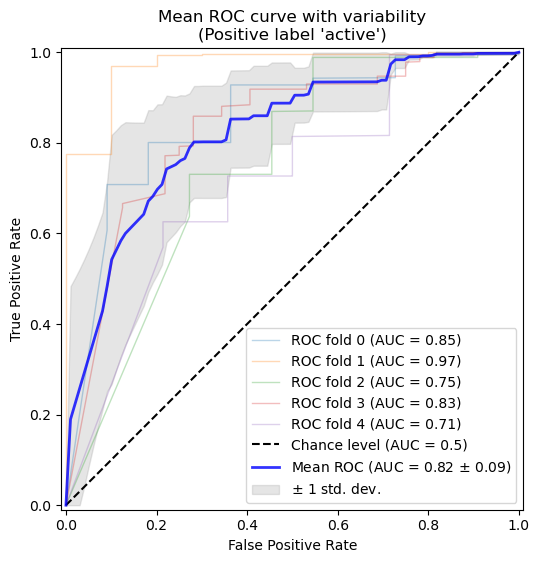

In [86]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(StraGroupKFold3.split(x, y, groups=groups_int)):
    model3.fit(x[train], y.iloc[train])
    viz = RocCurveDisplay.from_estimator(
        model3,
        x[test],
        y.iloc[test],
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
        plot_chance_level=(fold == num_folds - 1),
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability\n(Positive label 'active')",
)
ax.legend(loc="lower right")
plt.show()

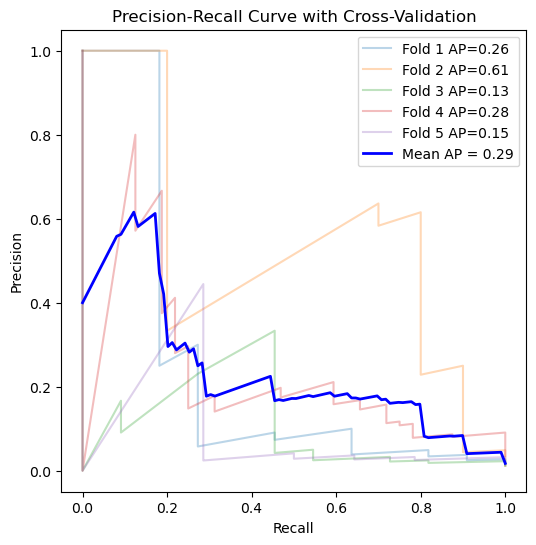

In [87]:
precisions = []
recalls = []
aps = []
mean_recall = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(6, 6))

for fold, (train_idx, test_idx) in enumerate(StraGroupKFold3.split(x, y, groups=groups_int)):
    model3.fit(x[train_idx], y.iloc[train_idx])

    y_pred_prob = model3.predict_proba(x[test_idx])[:, 0]

    precision, recall, _ = precision_recall_curve(y.iloc[test_idx], y_pred_prob, pos_label= "active")
    ap = average_precision_score(y.iloc[test_idx], y_pred_prob, pos_label= "active")

    interp_precision = np.interp(mean_recall, recall[::-1], precision[::-1])

    precisions.append(interp_precision)
    aps.append(ap)

    ax.plot(recall, precision, alpha=0.3, label=f'Fold {fold+1} AP={ap:.2f}')

mean_precision = np.mean(precisions, axis=0)
mean_ap = np.mean(aps)

ax.plot(mean_recall, mean_precision, color='b', lw=2, label=f'Mean AP = {mean_ap:.2f}')
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Precision-Recall Curve with Cross-Validation")
ax.legend()
plt.show()

In [88]:
pr_auc_values_3 = pd.DataFrame(data = [0.29], index= ['LabelPropagation (g.s)'])

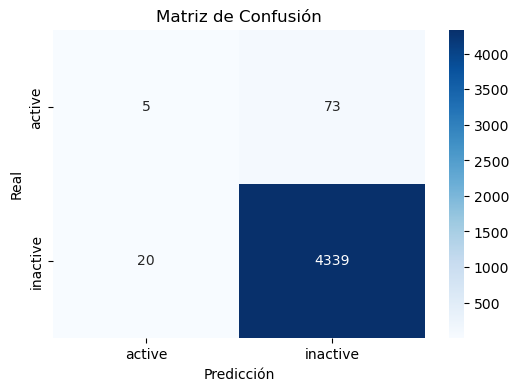

In [89]:
y_prediction_3 = cross_val_predict(model3, x, y, cv=StraGroupKFold3, groups=groups_int)

cm_3 = confusion_matrix(y, y_prediction_3)

plt.figure(figsize=(6,4))
sns.heatmap(cm_2, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

# **Overview of model metrics Comparison**

In [90]:
pr_auc_total_values = pd.concat([pr_auc_values_1, pr_auc_values_2, pr_auc_values_3], axis=0)

df_models_comparison = pd.concat([df_model_1, df_model_2, df_model_3], axis=0)
df_models_comparison.insert(2, "pr_auc", pr_auc_total_values.values)
df_models_comparison.index = ['RandomForestClassifier (g.s)', 'ExtraTreesClassifier (g.s)', 'LabelSpreading (g.s)']
df_models_comparison = df_models_comparison.style.set_properties(**{'text-align': 'center'})
df_models_comparison = df_models_comparison.format(precision=2)
df_models_comparison

,balanced_accuracy,roc_auc,pr_auc,matthews_corrcoef,f1_weighted,precision_weighted,recall_weighted,specificity_weighted
RandomForestClassifier (g.s),0.55,0.84,0.28,0.11,0.97,0.97,0.98,0.11
ExtraTreesClassifier (g.s),0.54,0.76,0.22,0.11,0.97,0.97,0.98,0.11
LabelSpreading (g.s),0.61,0.82,0.29,0.21,0.97,0.97,0.98,0.25


# **Save Model**

In [ ]:
with open('LabelSpreading_rdrp_sarscov2_model_trained.pkl', 'wb') as f:
    pickle.dump(model3, f)
